In [50]:
# ---------------------------------------------
#   WNBA PLAYER PERFORMANCE + SALARY MODEL
# ---------------------------------------------

import pandas as pd
import numpy as np

# --- Load WNBA Data ---
wnba = pd.read_csv("Full WNBA Dataset.csv")

# --- Fill missing numeric values with 0 ---
numeric_cols = ['FP','AGE','FGM','FGA','FTA','DREB','BLK','PTS','TOV','L','PF','STL','FT%','ERROR','MIN']
for col in numeric_cols:
    if col in wnba.columns:
        wnba[col] = wnba[col].fillna(0)

# --- Feature Importances from XGBoost ---
feat_importance = {
    'FP': 0.379349,
    'AGE': 0.080611,
    'FGM': 0.071855,
    'FTA': 0.042036,
    'FGA': 0.038424,
    'DREB': 0.031454,
    'BLK': 0.028346,
    'PTS': 0.027907,
    'TOV': 0.027045,
    'L': 0.023641,
    'PF': 0.023190,
    'STL': 0.023018,
    'FT%': 0.022908,
    'ERROR': 0.022655,
    'MIN': 0.022253
}

# --- Compute Weighted Performance Index ---
wnba['Performance_Index_Raw'] = 0
for feature, weight in feat_importance.items():
    if feature in wnba.columns:
        wnba['Performance_Index_Raw'] += wnba[feature] * weight

# --- Normalize to 0–100 ---
wnba['Performance_Index'] = 100 * (
    (wnba['Performance_Index_Raw'] - wnba['Performance_Index_Raw'].min()) /
    (wnba['Performance_Index_Raw'].max() - wnba['Performance_Index_Raw'].min())
)
wnba['Performance_Index'] = wnba['Performance_Index'].round(2)

# --- Create 10 tiers (Tier 1 = best) ---
wnba = wnba.sort_values(by='Performance_Index', ascending=False).reset_index(drop=True)
wnba['Tier'] = pd.qcut(wnba['Performance_Index'], q=10, labels=False)
wnba['Tier'] = 11 - (wnba['Tier'] + 1)  # Reverse ranking

# -------------------------------------------------------
# WNBA REVENUE BY YEAR + PLAYER SHARE (9.3%)
# -------------------------------------------------------
revenue_by_year = {
    2021: 110_000_000,   # estimate
    2022: 140_000_000,   # estimate
    2023: 190_000_000,   # Bloomberg range mid-point
    2024: 200_000_000,   # reported estimate
    2025: 250_000_000    # projection
}

player_share_pct = 0.5  # 9.3% CBA revenue share

# --- Compute payroll available per season ---
payroll_by_year = {year: rev * player_share_pct for year, rev in revenue_by_year.items()}

# -------------------------------------------------------
#   SALARY CALCULATION BASED ON PERFORMANCE INDEX
# -------------------------------------------------------

wnba['Predicted_Salary'] = 0.0

# Process year-by-year
for season, payroll in payroll_by_year.items():

    # Filter players for this season
    season_players = wnba[wnba['Season'] == season]

    if len(season_players) == 0:
        continue  # skip years not in the dataset

    # Sum of performance index for the year
    total_index = season_players['Performance_Index'].sum()

    if total_index == 0:
        continue

    # Each player's salary share = (PI / total PI of that season)
    wnba.loc[wnba['Season'] == season, 'Predicted_Salary'] = \
        season_players['Performance_Index'] / total_index * payroll

# Clean formatting
wnba['Predicted_Salary'] = wnba['Predicted_Salary'].round(2)

# -------------------------------------------------------
#   SAVE RESULTS
# -------------------------------------------------------
wnba[['PLAYER', 'Season', 'Tier', 'Performance_Index', 'Predicted_Salary']].to_csv(
    "WNBA_Performance_Index_SalaryModel.csv",
    index=False
)

# Preview output
print(" WNBA Salaries Computed Using Performance Index + Revenue Share")
print(wnba[['PLAYER', 'Season', 'Tier', 'Performance_Index', 'Predicted_Salary']].head(20).to_string(index=False))


 WNBA Salaries Computed Using Performance Index + Revenue Share
          PLAYER  Season  Tier  Performance_Index  Predicted_Salary
     a'ja wilson    2024     1             100.00        1833943.73
     jewell loyd    2023     1              93.74        1523977.23
arike ogunbowale    2024     1              92.65        1699148.87
     a'ja wilson    2025     1              91.55        1986503.49
 breanna stewart    2023     1              90.24        1467076.01
    tina charles    2021     1              90.10         875622.86
napheesa collier    2025     1              89.69        1946144.17
napheesa collier    2023     1              87.66        1425131.69
arike ogunbowale    2023     1              87.62        1424481.39
     a'ja wilson    2023     1              87.34        1419929.29
 breanna stewart    2021     1              86.14         837138.21
   caitlin clark    2024     1              85.71        1571873.17
napheesa collier    2024     1              85.39   

In [57]:
# -------------------------------------------------------
#   MULTIPLE PLAYER SHARE SCENARIOS
# -------------------------------------------------------

player_share_values = {
    "9_3pct": 0.093,
    "20pct": 0.20,
    "50pct": 0.50
}

for label, pct in player_share_values.items():
    payroll_by_year = {year: rev * pct for year, rev in revenue_by_year.items()}
    salary_col = f"Predicted_Salary_{label}"
    wnba[salary_col] = 0.0

    for season, payroll in payroll_by_year.items():
        season_players = wnba[wnba['Season'] == season]
        if len(season_players) == 0:
            continue
        total_index = season_players['Performance_Index'].sum()
        if total_index == 0:
            continue

        wnba.loc[wnba['Season'] == season, salary_col] = \
            season_players['Performance_Index'] / total_index * payroll

    wnba[salary_col] = wnba[salary_col].round(2)


In [58]:
cols_to_show = [
    'PLAYER', 'Season', 'Tier', 'Performance_Index',
    'Predicted_Salary_9_3pct',
    'Predicted_Salary_20pct',
    'Predicted_Salary_50pct'
]

print("\n WNBA Salaries Computed Using Performance Index + Revenue Share Scenarios")
print(wnba[cols_to_show].head(20).to_string(index=False))



 WNBA Salaries Computed Using Performance Index + Revenue Share Scenarios
          PLAYER  Season  Tier  Performance_Index  Predicted_Salary_9_3pct  Predicted_Salary_20pct  Predicted_Salary_50pct
     a'ja wilson    2024     1             100.00                341113.53               733577.49              1833943.73
     jewell loyd    2023     1              93.74                283459.77               609590.89              1523977.23
arike ogunbowale    2024     1              92.65                316041.69               679659.55              1699148.87
     a'ja wilson    2025     1              91.55                369489.65               794601.40              1986503.49
 breanna stewart    2023     1              90.24                272876.14               586830.41              1467076.01
    tina charles    2021     1              90.10                162865.85               350249.14               875622.86
napheesa collier    2025     1              89.69               

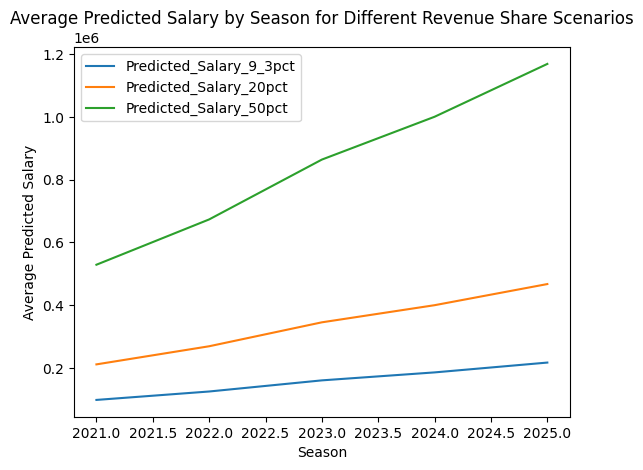

In [61]:
# make a visualization that has a bundle of lines for each predicted salary scenario by year
import matplotlib.pyplot as plt
salary_scenarios = [
    'Predicted_Salary_9_3pct',
    'Predicted_Salary_20pct',
    'Predicted_Salary_50pct'
]
for scenario in salary_scenarios:
    avg_salary_by_year = wnba.groupby('Season')[scenario].mean().reset_index()
    plt.plot(avg_salary_by_year['Season'], avg_salary_by_year[scenario], label=scenario)
plt.xlabel('Season')
plt.ylabel('Average Predicted Salary')
plt.title('Average Predicted Salary by Season for Different Revenue Share Scenarios')
plt.legend()
plt.show()


In [ ]:
# add a line to this graph that shows a gradual increase from 


 Total Underpaid Players: 399 out of 525 (76.0%)


In [56]:
output_cols = [
    'PLAYER', 'Season', 'Tier', 'Performance_Index',
    'Salary_093', 'Salary_20', 'Salary_50'
]

wnba[output_cols].to_csv("WNBA_Perf_Index_SalaryModel_3Scenarios.csv", index=False)

print("\nWNBA Salaries Under Multiple Revenue Shares")
print(wnba[output_cols].head(20).to_string(index=False))


KeyError: "['Salary_093', 'Salary_20', 'Salary_50'] not in index"

In [54]:
# ---------------------------------------------
#   WNBA PLAYER PERFORMANCE + SALARY MODEL
# ---------------------------------------------

import pandas as pd
import numpy as np

# --- Load WNBA Data ---
wnba = pd.read_csv("Full WNBA Dataset.csv")

# --- Fill missing numeric values with 0 ---
numeric_cols = ['FP','AGE','FGM','FGA','FTA','DREB','BLK','PTS','TOV','L','PF','STL','FT%','ERROR','MIN','SALARY']
for col in numeric_cols:
    if col in wnba.columns:
        wnba[col] = wnba[col].fillna(0)

# --- Feature Importances from XGBoost ---
feat_importance = {
    'FP': 0.379349,
    'AGE': 0.080611,
    'FGM': 0.071855,
    'FTA': 0.042036,
    'FGA': 0.038424,
    'DREB': 0.031454,
    'BLK': 0.028346,
    'PTS': 0.027907,
    'TOV': 0.027045,
    'L': 0.023641,
    'PF': 0.023190,
    'STL': 0.023018,
    'FT%': 0.022908,
    'ERROR': 0.022655,
    'MIN': 0.022253
}

# --- Compute Weighted Performance Index ---
wnba['Performance_Index_Raw'] = 0
for feature, weight in feat_importance.items():
    if feature in wnba.columns:
        wnba['Performance_Index_Raw'] += wnba[feature] * weight

# --- Normalize to 0–100 ---
wnba['Performance_Index'] = 100 * (
    (wnba['Performance_Index_Raw'] - wnba['Performance_Index_Raw'].min()) /
    (wnba['Performance_Index_Raw'].max() - wnba['Performance_Index_Raw'].min())
)
wnba['Performance_Index'] = wnba['Performance_Index'].round(2)

# --- Create 10 tiers (Tier 1 = best) ---
wnba = wnba.sort_values(by='Performance_Index', ascending=False).reset_index(drop=True)
wnba['Tier'] = pd.qcut(wnba['Performance_Index'], q=10, labels=False)
wnba['Tier'] = 11 - (wnba['Tier'] + 1)  # Reverse ranking

# -------------------------------------------------------
# WNBA REVENUE BY YEAR + PLAYER SHARE
# -------------------------------------------------------
revenue_by_year = {
    2021: 110_000_000,
    2022: 140_000_000,
    2023: 190_000_000,
    2024: 200_000_000,
    2025: 250_000_000
}

player_share_pct = 0.093   # 50% revenue to players
payroll_by_year = {year: rev * player_share_pct for year, rev in revenue_by_year.items()}

# -------------------------------------------------------
#   SALARY CALCULATION BASED ON PERFORMANCE INDEX
# -------------------------------------------------------

wnba['New_Salary'] = 0.0

for season, payroll in payroll_by_year.items():

    season_players = wnba[wnba['Season'] == season]
    if len(season_players) == 0:
        continue

    total_index = season_players['Performance_Index'].sum()
    if total_index == 0:
        continue

    # Salary = performance share * pool
    wnba.loc[wnba['Season'] == season, 'New_Salary'] = (
        season_players['Performance_Index'] / total_index * payroll
    )

wnba['New_Salary'] = wnba['New_Salary'].round(2)

# -------------------------------------------------------
#   COMPARE PREDICTED VS ACTUAL SALARY
# -------------------------------------------------------

wnba['Salary_Diff'] = (wnba['New_Salary'] - wnba['SALARY']).round(2)
wnba['Underpaid'] = wnba['Salary_Diff'] > 0
wnba['Percent_Diff'] = np.where(
    wnba['SALARY'] > 0,
    (wnba['New_Salary'] - wnba['SALARY']) / wnba['SALARY'],
    np.nan
)
wnba['Percent_Diff'] = (wnba['Percent_Diff'] * 100).round(2)

# -------------------------------------------------------
#   SAVE COMPARISON RESULTS
# -------------------------------------------------------

comparison_cols = [
    'PLAYER', 'Season', 'Tier', 'Performance_Index',
    'SALARY', 'New_Salary', 'Salary_Diff',
    'Percent_Diff', 'Underpaid'
]

wnba[comparison_cols].to_csv("WNBA_Predicted_vs_Actual_Salary.csv", index=False)

# -------------------------------------------------------
#   PREVIEW OUTPUT
# -------------------------------------------------------
print("Comparison of Predicted vs Actual Salaries")
print(wnba[comparison_cols].head(20).to_string(index=False))


Comparison of Predicted vs Actual Salaries
          PLAYER  Season  Tier  Performance_Index  SALARY  New_Salary  Salary_Diff  Percent_Diff  Underpaid
     a'ja wilson    2024     1             100.00  227303   341113.53    113810.53         50.07       True
     jewell loyd    2023     1              93.74  234936   283459.77     48523.77         20.65       True
arike ogunbowale    2024     1              92.65  241984   316041.69     74057.69         30.60       True
     a'ja wilson    2025     1              91.55  200000   369489.65    169489.65         84.74       True
 breanna stewart    2023     1              90.24  180000   272876.14     92876.14         51.60       True
    tina charles    2021     1              90.10  175000   162865.85    -12134.15         -6.93      False
napheesa collier    2025     1              89.69  214284   361982.81    147698.81         68.93       True
napheesa collier    2023     1              87.66  202154   265074.49     62920.49         31

In [45]:
# evaluate what percent of players in each tier are underpaid based on the model
tier_summary = wnba.groupby('Tier').agg(
    Total_Players=('PLAYER', 'count'),
    Underpaid_Players=('Underpaid', 'sum')
)
tier_summary['Percent_Underpaid'] = (
    tier_summary['Underpaid_Players'] / tier_summary['Total_Players'] * 100
).round(2)


print("\n Underpaid Players by Tier")
print(tier_summary.reset_index().to_string(index=False))



 Underpaid Players by Tier
 Tier  Total_Players  Underpaid_Players  Percent_Underpaid
    1             53                 41              77.36
    2             52                 44              84.62
    3             53                 28              52.83
    4             52                 35              67.31
    5             52                 39              75.00
    6             53                 43              81.13
    7             52                 45              86.54
    8             53                 45              84.91
    9             52                 40              76.92
   10             53                 39              73.58


In [47]:
# show me total underpaid stats, anywhy you know how
total_underpaid = wnba[wnba['Underpaid']].shape[0]
total_players = wnba.shape[0]
percent_underpaid = (total_underpaid / total_players * 100)
print(f"\n Total Underpaid Players: {total_underpaid} out of {total_players} ({percent_underpaid}%)")



 Total Underpaid Players: 399 out of 525 (76.0%)


/var/folders/5_/4h01d9r90pg9x4bv3gr01rvm0000gn/T/ipykernel_45894/3598237055.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tier_summary.index, y='Percent_Underpaid', data=tier_summary, palette='viridis')


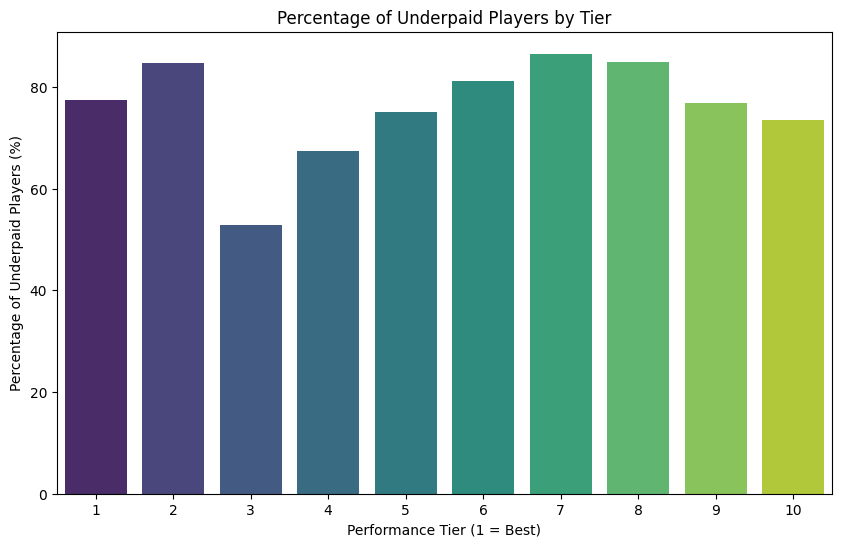

In [34]:
# now visualize this data
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=tier_summary.index, y='Percent_Underpaid', data=tier_summary, palette='viridis')
plt.title('Percentage of Underpaid Players by Tier')
plt.xlabel('Performance Tier (1 = Best)')
plt.ylabel('Percentage of Underpaid Players (%)')
plt.show()

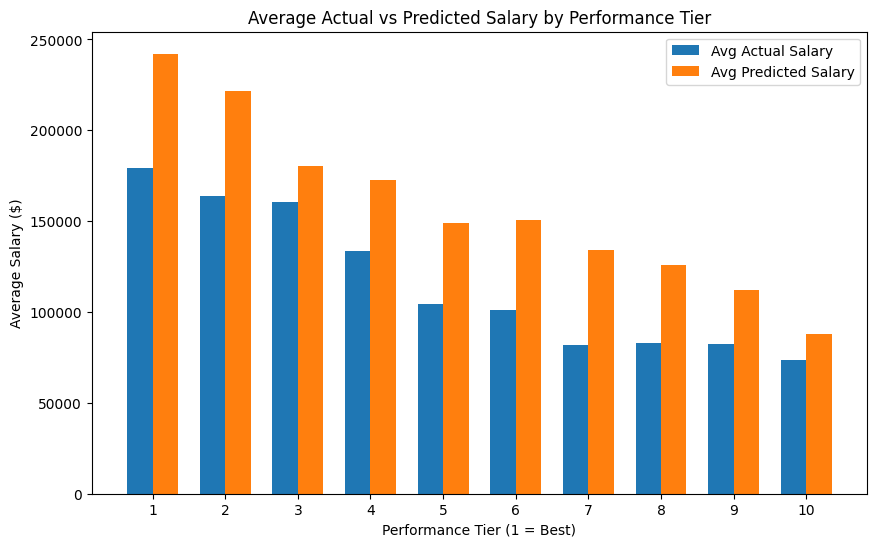

In [35]:
# create a grouped bar chart comparing average actual salary vs predicted salary by tier
avg_salary_by_tier = wnba.groupby('Tier').agg(
    Avg_Actual_Salary=('SALARY', 'mean'),
    Avg_Predicted_Salary=('New_Salary', 'mean')
).reset_index() 
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(avg_salary_by_tier['Tier']))
plt.bar(x - bar_width/2, avg_salary_by_tier['Avg_Actual_Salary'], width=bar_width, label='Avg Actual Salary')
plt.bar(x + bar_width/2, avg_salary_by_tier['Avg_Predicted_Salary'], width=bar_width, label='Avg Predicted Salary')
plt.xlabel('Performance Tier (1 = Best)')
plt.ylabel('Average Salary ($)')
plt.title('Average Actual vs Predicted Salary by Performance Tier')
plt.xticks(x, avg_salary_by_tier['Tier'])
plt.legend()
plt.show()

In [43]:
# print the difference average predicted vs average actual salary by tier by percentage difference, rounded to 2 decimal places
avg_salary_by_tier['Salary_Diff'] = (
    avg_salary_by_tier['Avg_Predicted_Salary'] - avg_salary_by_tier['Avg_Actual_Salary']
).round(2)
avg_salary_by_tier['Percent_Diff'] = np.where(
    avg_salary_by_tier['Avg_Actual_Salary'] > 0,
    (avg_salary_by_tier['Avg_Predicted_Salary'] - avg_salary_by_tier['Avg_Actual_Salary']) / avg_salary_by_tier['Avg_Actual_Salary'] * 100,
    np.nan
).round(2)
print("\n Average Salary Comparison by Tier")
print(avg_salary_by_tier[['Tier', 'Avg_Actual_Salary', 'Avg_Predicted_Salary', 'Salary_Diff', 'Percent_Diff']].to_string(index=False))


 Average Salary Comparison by Tier
 Tier  Avg_Actual_Salary  Avg_Predicted_Salary  Salary_Diff  Percent_Diff
    1      179355.000000         242125.215849     62770.22         35.00
    2      163683.788462         221836.789808     58153.00         35.53
    3      160266.566038         180412.486792     20145.92         12.57
    4      133671.269231         172699.059423     39027.79         29.20
    5      104334.057692         148810.153846     44476.10         42.63
    6      100869.094340         150392.252453     49523.16         49.10
    7       81962.153846         134251.072308     52288.92         63.80
    8       82892.603774         125748.207736     42855.60         51.70
    9       82655.865385         112299.226154     29643.36         35.86
   10       73541.207547          88027.353585     14486.15         19.70


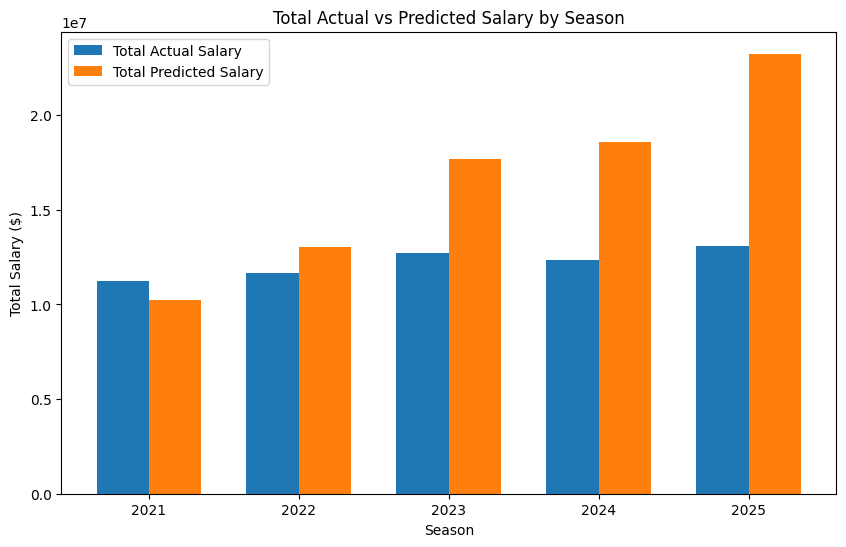

In [37]:
# show actual vs predicted total salary by year
actual_vs_predicted_by_year = wnba.groupby('Season').agg(
    Total_Actual_Salary=('SALARY', 'sum'),
    Total_Predicted_Salary=('New_Salary', 'sum')
).reset_index()
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(actual_vs_predicted_by_year['Season']))
plt.bar(x - bar_width/2, actual_vs_predicted_by_year['Total_Actual_Salary'], width=bar_width, label='Total Actual Salary')
plt.bar(x + bar_width/2, actual_vs_predicted_by_year['Total_Predicted_Salary'], width=bar_width, label='Total Predicted Salary')
plt.xlabel('Season')
plt.ylabel('Total Salary ($)')
plt.title('Total Actual vs Predicted Salary by Season')
plt.xticks(x, actual_vs_predicted_by_year['Season'])
plt.legend()
plt.show()

In [38]:
# show me the percent increase in percentage total predicted salary by year from previous year
actual_vs_predicted_by_year['Percent_Increase_Predicted'] = actual_vs_predicted_by_year['Total_Predicted_Salary'].pct_change() * 100
print("\n Percent Increase in Total Predicted Salary by Year")
print(actual_vs_predicted_by_year[['Season', 'Percent_Increase_Predicted']].to_string(index=False))


 Percent Increase in Total Predicted Salary by Year
 Season  Percent_Increase_Predicted
   2021                         NaN
   2022                   27.272727
   2023                   35.714286
   2024                    5.263158
   2025                   25.000000
